In [388]:
import torch
import math
import poppy.zernike
import numpy as np

In [389]:
# Mesh/aperture
def make_xy_mesh(H:int,W:int,device=None,dtype=torch.float32):
    # Normalized coordinates in [-1,1]
    y = torch.linspace(-1,1,H,device=device,dtype=dtype)
    x = torch.linspace(-1,1,W,device=device,dtype=dtype)
    yy, xx = torch.meshgrid(y,x,indexing='ij')
    return xx,yy

In [390]:
def circular_pupil(xx:torch.Tensor,yy:torch.Tensor,NA:float=1.0):
    # NA is relative to the max radius (1.0)
    r2 = xx**2 + yy**2
    pupil = (r2 <= NA**2).to(xx.dtype)
    return pupil.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

In [391]:
# Zernike polynomials
def zernike_basis_with_poppy(xx:torch.Tensor,yy:torch.Tensor,nm_list):
    """ 
    Generate Zernike basis using poppy.zernike module.
    Args:
        xx: [H,W] meshgrid x-coordinates in normalized units [-1,1]
        yy: [H,W] meshgrid y-coordinates in normalized units [-1,1]
        nm_list: list of (n,m) tuples for Zernike polynomials
    Returns:
        basis: [len(nm_list), H, W] tensor of Zernike basis functions
    """
    H,W = xx.shape
    device = xx.device
    dtype = xx.dtype

    # change to numpy for poppy
    xx_np = xx.cpu().numpy()
    yy_np = yy.cpu().numpy()

    # calculate radius and angle
    rho_np = np.sqrt(xx_np**2 + yy_np**2)
    theta_np = np.arctan2(yy_np, xx_np)

    mask_np = (rho_np <= 1.0)

    Zs_list_np = []
    for (n,m) in nm_list:

        Z_np = poppy.zernike.zernike(n, m, rho=rho_np, theta=theta_np)
        Z_np = Z_np * mask_np  # mask outside unit circle
        Z_np = np.nan_to_num(Z_np,nan=0.0)  # replace NaN with 0
        Zs_list_np.append(Z_np)

    Z_stack_np = np.stack(Zs_list_np, axis=0)  # [num_basis, H, W]

    Z_stack_torch = torch.from_numpy(Z_stack_np).to(device=device,dtype=dtype)
    return Z_stack_torch # [num_basis, H, W]

In [392]:
# Phase synthesis
# Zernike phase 
def zernike_phase(coeffs:torch.Tensor,Z:torch.Tensor):
    """ 
    coeffs: [num_basis]
    Z: [num_basis, H, W]
    Returns:
        phase: [1,1,H,W]
    """
    assert coeffs.ndim == 1 and Z.ndim == 3 and coeffs.shape[0] == Z.shape[0]
    phi = torch.einsum('t, thw -> hw', coeffs, Z)  # [H,W]
    return phi.unsqueeze(0).unsqueeze(0)  # [1,1,H,W] 

In [393]:
# Defocus phase
def defocus_phase(defocus_amounts:torch.Tensor,xx:torch.Tensor,yy:torch.Tensor):
    """
    defocus_amounts:[K] 
    Returns:
        phase: [K,1,H,W] 
    """
    rho2 = (xx**2 + yy**2).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return defocus_amounts.view(-1,1,1,1) * rho2  # [K,1,H,W]
    

In [394]:
# Mixed phase
def mixed_phase(phi_zernike:torch.Tensor,phi_defocus:torch.Tensor,wavelengths:torch.Tensor,scale_by_wavelength:bool=True):
    """
    phi_zernike: [1,1,H,W]
    phi_defocus: [K,1,H,W]
    Returns:
        phase: [K,1,H,W]
    """
    K,_,H,W = phi_defocus.shape
    C = wavelengths.numel()
    phi = phi_zernike.expand(K,1,H,W) + phi_defocus  # [K,1,H,W]
    phi = phi.expand(K,C,H,W)  # [K,C,H,W]
    if scale_by_wavelength:
        two_pi_over_lambda = (2*math.pi / wavelengths).view(1,C,1,1)  # [1,C,1,1]
        phi = phi * two_pi_over_lambda  # [K,C,H,W]
    return phi  # [K,C,H,W]

In [395]:
# From phase to PSF
def psf_from_phase(pupil_amp:torch.Tensor,phi:torch.Tensor,do_fftshift:False):
    """ 
    pupil_amp: [1,1,H,W]
    phi: [K,C,H,W]
    Returns:
        psf: [K,C,H,W]
    """
    K,C,H,W = phi.shape
    phi = torch.nan_to_num(phi,nan=0.0,posinf=0.0,neginf=0.0)
    mask = (pupil_amp > 0).to(phi.dtype)
    phi = phi * mask  # zero out phase where pupil is zero
    pupil = pupil_amp.expand(K,1,H,W)
    U = pupil.to(phi.dtype) * torch.exp(1j * phi)  # [K,C,H,W]

    U = torch.fft.fft2(U, dim=(-2,-1),norm='ortho')  # [K,C,H,W]
    if do_fftshift:
        U = torch.fft.fftshift(U, dim=(-2,-1))
    psf = (U.conj() * U).real  # [K,C,H,W]
    psf = psf / psf.sum(dim=(-2,-1),keepdim=True).clamp_min(1e-12)  # normalize energy
    return psf  # [K,C,H,W]

In [396]:
# Combine
def zernike_defocus_psf(H:int,W:int,
                        nm_list,
                        coeffs,
                        defocus_amounts:torch.Tensor,
                        wavelengths:torch.Tensor,
                        NA:float=1.0,
                        scale_by_wavelength:bool=True,
                        do_fftshift:bool=True,
                        device=None,
                        dtype=torch.float32):
    """
    Returns:
        psf: [K,C,H,W]
    """
    # Mesh
    xx,yy = make_xy_mesh(H,W,device=device,dtype=dtype)  # [H,W]

    # Pupil
    pupil_amp = circular_pupil(xx,yy,NA=NA)  # [1,1,H,W]

    # Zernike basis
    Z = zernike_basis_with_poppy(xx,yy,nm_list)  # [num_basis,H,W]

    # Zernike phase
    coeffs_tensor = torch.as_tensor(coeffs,device=device,dtype=dtype)
    phi_zernike = zernike_phase(coeffs_tensor,Z)  # [1,1,H,W]

    # Defocus phase
    defocus_tensor = torch.as_tensor(defocus_amounts,device=device,dtype=dtype)
    phi_defocus = defocus_phase(defocus_tensor,xx,yy)  # [K,1,H,W]

    # Mixed phase
    wave_tensor = torch.as_tensor(wavelengths,device=device,dtype=dtype)
    phi = mixed_phase(phi_zernike,phi_defocus,wave_tensor,scale_by_wavelength=scale_by_wavelength)  # [K,C,H,W]

    # PSF
    psf = psf_from_phase(pupil_amp,phi,do_fftshift=do_fftshift)  # [K,C,H,W]

    return psf  # [K,C,H,W]

In [397]:
# Example usage
H = W = 256
nm_list = [(2,2), (3,1)]       
coeffs  = [-0.5, 0.2]
defocus = torch.linspace(-100, 100, steps=5)
wavelengths = torch.tensor([550e-9])   # Green channel, in meters

psf = zernike_defocus_psf(
    H, W, nm_list, coeffs, defocus, wavelengths,
    NA=1.0, scale_by_wavelength=False, do_fftshift=True
)
print(psf.shape)             # Expected: torch.Size([5, 1, 256, 256])
print(psf.sum((-2,-1)))      # Normalized energy



torch.Size([5, 1, 256, 256])
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])


nan? False
per (k,c) energy ~1? -> tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])


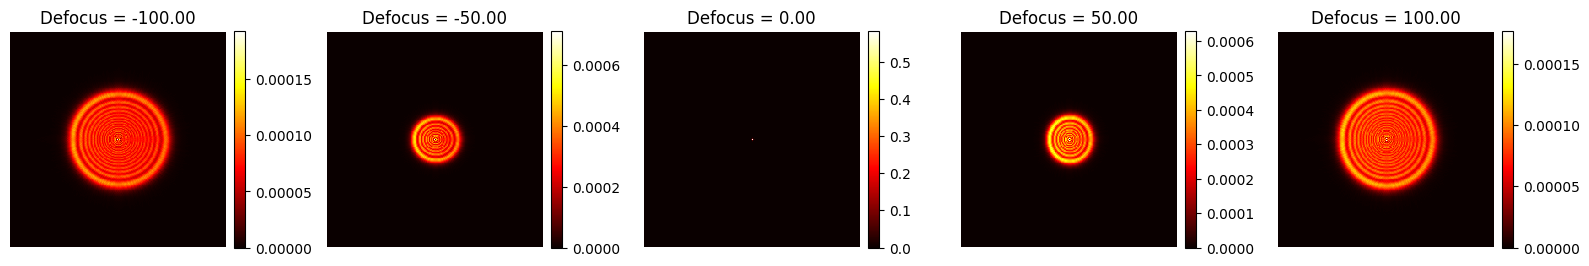

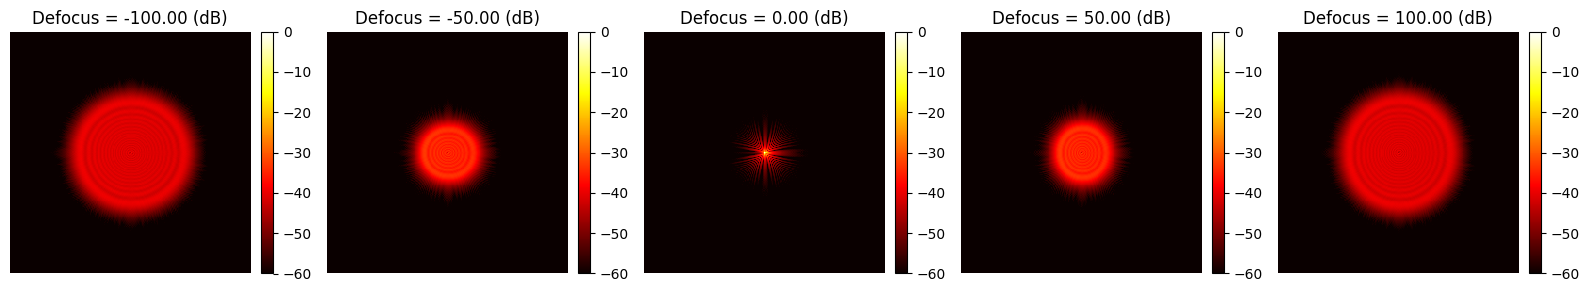

In [ ]:
# === Quick diagnostics ===
print('nan?', torch.isnan(psf).any().item())
print('per (k,c) energy ~1? ->', psf.sum(dim=(-1,-2)))

# ===== Visualization of PSFs (better scaling) =====
import matplotlib.pyplot as plt
import numpy as np
import math

K, C, H, W = psf.shape
assert C == 1  # single channel
psf_np = psf[:, 0].cpu().numpy()  # [K,H,W]

ncol = min(5, K)
nrow = math.ceil(K / ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(3.2*ncol, 3.2*nrow))
axes = axes.ravel() if K > 1 else [axes]

# Method A : Linear-scale display + individual color scales
for i in range(nrow*ncol):
    ax = axes[i]
    ax.axis('off')
    if i < K:
        p = psf_np[i]
        vmin, vmax = p.min(), p.max()
        im = ax.imshow(p, cmap='hot', vmin=vmin, vmax=vmax, interpolation='nearest')
        ax.set_title(f"Defocus = {float(defocus[i]):.2f}")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Method B : Log-scale display + Unified color scale
eps = 1e-12
psf_db = 10.0 * np.log10(np.maximum(psf_np, eps))  # [K,H,W]
vmin_db, vmax_db = -60.0, 0.0                      # [-60, 0] dB
fig, axes = plt.subplots(nrow, ncol, figsize=(3.2*ncol, 3.2*nrow))
axes = axes.ravel() if K > 1 else [axes]
for i in range(nrow*ncol):
    ax = axes[i]
    ax.axis('off')
    if i < K:
        im = ax.imshow(psf_db[i], cmap='hot', vmin=vmin_db, vmax=vmax_db, interpolation='nearest')
        ax.set_title(f"Defocus = {float(defocus[i]):.2f} (dB)")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
